Using less data. Spliting train data (Features and tokenized captions)
Using InceptionV3 for feature extraction instead

Load imports 

In [2]:
import pickle
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
import random 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
import keras_nlp

Open and load the pickle feature file and tokenizer files for train

In [3]:
# Load train image features
with open('incep/train2014_features2.pkl', 'rb') as f:
    image_features = pickle.load(f)

# Load train tokienezd captions
with open('tokenized_train_captions2.pkl', 'rb') as f:
    tokenized_captions = pickle.load(f)

# Load tokenizer 
with open('tokenizer2.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Print traininfo
print('Train Photos (with features):', len(image_features))

count = len(tokenizer.word_index) + 1 # add one for the encoding to work at max index
max_len = max(len(i) for j in tokenized_captions.values() for i in j) # max length of words in a caption 
print("Unique word count in vocabulary ",count) # check vocabularu count length 
print("Max length of words in a caption ",max_len) # check max length of words in a caption count 

Train Photos (with features): 82783
Unique word count in vocabulary  24784
Max length of words in a caption  51


In [4]:
print(type(tokenizer))
print(type(image_features))
print(type(tokenized_captions))

first_key = list(image_features.keys())[0]  # get the first image ID
print("Example of first image feature id:", first_key)
print("Example of first image feature value:", image_features.get(first_key))

<class 'keras.src.legacy.preprocessing.text.Tokenizer'>
<class 'dict'>
<class 'dict'>
Example of first image feature id: COCO_train2014_000000000009
Example of first image feature value: [0.36421552 0.39731848 0.8489207  ... 0.07712217 0.5497141  0.54330546]


Split train features and train tokenized captions into train and test 

In [5]:
def divide_dataset(features,captions):
    training_features = {} # create a train dictionary 
    training_captions = {}
    validation_features = {} # create a validation dictionary 
    validation_captions = {}

    dataset_keys = list(features.keys())  # All available keys
    dataset_size = len(dataset_keys)

    split_percentage = .80 
    train_sample_count = int(dataset_size * split_percentage)

    random_train_sample_keys = random.sample(dataset_keys, train_sample_count)
    validation_sample_keys = list(set(dataset_keys) - set(random_train_sample_keys))

    # fill training dictionaries
    for key in random_train_sample_keys:
        if key in features and key in captions:
            training_features[key] = features[key]
            training_captions[key] = captions[key]

    # fill validation dictionaries
    for key in validation_sample_keys:
        if key in features and key in captions:
            validation_features[key] = features[key]
            validation_captions[key] = captions[key]

    return training_features, training_captions, validation_features, validation_captions 

Creating data generator 

In [6]:
def create_sequences(tokenizer, max_length, captions, image_feature, vocab_size):
    X1, X2, y = list(), list(), list() 
    
    for seq in captions:  # loop through seq which is a list of integers
        for i in range(1, len(seq)): # loop throguh each integer 
            in_seq, out_seq = seq[:i], seq[i] # create input - output integers

            in_seq = pad_sequences([in_seq], maxlen=max_length)[0] # pad the input 
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0] # encode the output 

            X1.append(image_feature) # add to list
            X2.append(in_seq) # add to list 
            y.append(out_seq) # add to list 

    return np.array(X1), np.array(X2), np.array(y) # return array 

def data_generator(captions, features, tokenizer, max_length, vocab_size, batch_size):
    while True: 
        X1, X2, y = list(), list(), list() 

        for img_id, cap_list in captions.items(): # loop through each img id and caption pair 
            if img_id in features: # if id exists in image feature 
                image_feature = features[img_id] # get the feature vector 8x8x2048
                input_img, input_seq, output_word = create_sequences(tokenizer, max_length, cap_list, image_feature, vocab_size) # check sequences

                for i in range(len(input_img)): #loop through images features in array
                    X1.append(input_img[i]) # get img feature
                    X2.append(input_seq[i]) # get sequence
                    y.append(output_word[i]) # get predicted word 

                    if len(X1) == batch_size:
                        # yeild when needed 
                        yield (
                            (
                                np.array(X1, dtype='float32'),     # features
                                np.array(X2, dtype='int32')         # sequences
                            ),
                            np.array(y, dtype='float32')            # output words
                        )
                        X1, X2, y = list(), list(), list()


Creating CNN+LSTM Model

In [ ]:
def CNNLSTM_model(count,max_len): # vocbulary total count and max lenght of words for captions 
    # CNN input 
    input1 = Input(shape=(2048,)) # feature vector input shape is 2048 for ResNet50 
    dropout1 = Dropout(0.5)(input1) 
    dense_layer1 = Dense(256,activation='relu')(dropout1) 

    # LSTM
    input2 = Input(shape=(max_len,)) # caption vector input shape is the maxaium length 
    embed = Embedding(count,256,mask_zero=True)(input2)
    dropout2 = Dropout(0.5)(embed)
    dense_layer2 = LSTM(256)(dropout2)

    # Combiniding the models 
    decoder1= Add()([dense_layer1,dense_layer2])
    #decoder1 = tf.keras.layers.Concatenate()([dense_layer1, dense_layer2])
    decoder2 = Dense(256,activation='relu')(decoder1)
    outputs = Dense(count, activation = 'softmax')(decoder2)

    # Image and caption pair input and word output 
    model = Model(inputs=[input1,input2], outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001))
    model.summary()
    return model 

''' When using 8x8x2048 
def CNNLSTM_model(count,max_len): # vocbulary total count and max lenght of words for captions 
    # CNN input 
    input1 = Input(shape=(8,8,2048)) # feature vector input shape is 8X8X2048 for Inception V3
    flatten = Flatten()(input1)
    dropout1 = Dropout(0.5)(flatten) 
    dense_layer1 = Dense(256,activation='relu')(dropout1) 

    # LSTM
    input2 = Input(shape=(max_len,)) # caption vector input shape is the maxaium length 
    embed = Embedding(count,256,mask_zero=True)(input2)
    dropout2 = Dropout(0.5)(embed)
    dense_layer2 = LSTM(256)(dropout2)

    # Combiniding the models 
    #decoder1= Add()([dense_layer1,dense_layer2])
    decoder1 = tf.keras.layers.Concatenate()([dense_layer1, dense_layer2])
    decoder2 = Dense(256,activation='relu')(decoder1)
    outputs = Dense(count, activation = 'softmax')(decoder2)

    # Image and caption pair input and word output 
    model = Model(inputs=[input1,input2], outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001))
    model.summary()
    return model 
'''

"\ndef CNNLSTM_model(count,max_len): # vocbulary total count and max lenght of words for captions \n    # CNN input \n    input1 = Input(shape=(8,8,2048)) # feature vector input shape is 8X8X2048 for Inception V3\n    flatten = Flatten()(input1)\n    dropout1 = Dropout(0.5)(flatten) \n    dense_layer1 = Dense(256,activation='relu')(dropout1) \n\n    # LSTM\n    input2 = Input(shape=(max_len,)) # caption vector input shape is the maxaium length \n    embed = Embedding(count,256,mask_zero=True)(input2)\n    dropout2 = Dropout(0.5)(embed)\n    dense_layer2 = LSTM(256)(dropout2)\n\n    # Combiniding the models \n    #decoder1= Add()([dense_layer1,dense_layer2])\n    decoder1 = tf.keras.layers.Concatenate()([dense_layer1, dense_layer2])\n    decoder2 = Dense(256,activation='relu')(decoder1)\n    outputs = Dense(count, activation = 'softmax')(decoder2)\n\n    # Image and caption pair input and word output \n    model = Model(inputs=[input1,input2], outputs=outputs)\n    model.compile(loss = 

In [20]:
def CNNLSTM_model2(count,max_len): # vocbulary total count and max lenght of words for captions 
    # CNN input 
    input1 = Input(shape=(2048,)) # feature vector input shape is 2048 for ResNet50 
    dropout1 = Dropout(0.5)(input1) 
    dense_layer1 = Dense(256,activation='relu')(dropout1) 
    
    # LSTM
    input2 = Input(shape=(max_len,)) # caption vector input shape is the maxaium length 
    embed = Embedding(count,256,mask_zero=True)(input2)
    dropout2 = Dropout(0.5)(embed)
    lstm1= LSTM(256, return_sequences=True)(dropout2)
    dense_layer2 = LSTM(256)(lstm1)

    # Combiniding the models 
    decoder1= Add()([dense_layer1,dense_layer2])
    #decoder1 = tf.keras.layers.Concatenate()([dense_layer1, dense_layer2])
    decoder2 = Dense(256,activation='relu')(decoder1)
    outputs = Dense(count, activation = 'softmax')(decoder2)

    # Image and caption pair input and word output 
    model = Model(inputs=[input1,input2], outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001))
    model.summary()
    return model 

In [32]:
def CNNLSTM_model3(count,max_len): # vocbulary total count and max lenght of words for captions 
    # CNN input 
    input1 = Input(shape=(2048,)) # feature vector input shape is 2048 for ResNet50 
    dropout1 = Dropout(0.5)(input1) 
    dense_layer1 = Dense(256,activation='relu')(dropout1) 
    
    # LSTM
    input2 = Input(shape=(max_len,)) # caption vector input shape is the maxaium length 
    embed = Embedding(count,256,mask_zero=True)(input2)
    dropout2 = Dropout(0.5)(embed)
    lstm1= LSTM(256, return_sequences=True)(dropout2)
    dense_layer2 = LSTM(256)(lstm1)

    # Combiniding the models 
    decoder1= Add()([dense_layer1,dense_layer2])
    #decoder1 = tf.keras.layers.Concatenate()([dense_layer1, dense_layer2])
    decoder2 = Dense(256,activation='relu')(decoder1)
    outputs = Dense(count, activation = 'softmax')(decoder2)

    # Image and caption pair input and word output 
    model = Model(inputs=[input1,input2], outputs=outputs)
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.0001))
    model.summary()
    return model 

Training the model 

In [8]:
training_features, training_captions, validation_features, validation_captions = divide_dataset(image_features,tokenized_captions)

In [ ]:
# Make sure the model directory exists
os.makedirs("incep/model_3", exist_ok=True)

batch_size = 64
steps_per_epoch = len(training_features) // batch_size 

# Build the model
model3 = CNNLSTM_model3(count, max_len)
epochs = 30

# Prepare datasets only once
dataset_train = data_generator(training_captions, training_features, tokenizer, max_len, count, batch_size)

#Save the model after each epoch 

checkpoint_callback = ModelCheckpoint(
    "incep/model_3/model_epoch_{epoch:02d}.h5",  # Path to save the model (using epoch number in filename)
    monitor="loss",  # Monitor the loss for saving (you can also use validation loss, etc.)
    verbose=1,  # Print out information when saving
    save_best_only=False,  # Set to True to save only the best model based on monitored value
    save_weights_only=False,  # Set to True if you want to save only model weights, not the entire model
    mode="min",  # "min" means saving when the loss decreases; can be "max" for accuracy-based models
)

# Train the model once
model3.fit(
    dataset_train,  # Training data
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch for training
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpoint_callback] 
)

# Save the model after training
model3.save("incep/model_3/final_model.h5")

print("Training complete.")


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 51, 256)   │  6,344,704 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 51, 256)   │          0 │ embedding_8[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_8         │ (None, 51)        │          0 │ input_layer_17[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 2048)      │          0 │ input_layer_16[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 51, 256)   │    525,312 │ dropout_17[0][0], │
│                     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │    524,544 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 256)       │    525,312 │ lstm_14[0][0],    │
│                     │                   │            │ not_equal_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 256)       │          0 │ dense_22[0][0],   │
│                     │                   │            │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 256)       │     65,792 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 24784)     │  6,369,488 │ dense_23[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,355,152 (54.76 MB)

 Trainable params: 14,355,152 (54.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
 428/1034 ━━━━━━━━━━━━━━━━━━━━ 3:33 353ms/step - loss: 7.3345

In [ ]:
for i in range(10):
    get_captions(
        image_id=list(validation_features.keys())[i],
        image_captions=validation_captions, 
        image_features=validation_features, 
        image_path="./train2014", 
        model=model3,
        tokenizer=tokenizer,
        max_len=max_len
    )

In [21]:
# Make sure the model directory exists
os.makedirs("incep/model_2", exist_ok=True)

batch_size = 64
steps_per_epoch = len(training_features) // batch_size 

# Build the model
model2 = CNNLSTM_model2(count, max_len)
epochs = 15

# Prepare datasets only once
dataset_train = data_generator(training_captions, training_features, tokenizer, max_len, count, batch_size)

#Save the model after each epoch 

checkpoint_callback = ModelCheckpoint(
    "incep/model_2/model_epoch_{epoch:02d}.h5",  # Path to save the model (using epoch number in filename)
    monitor="loss",  # Monitor the loss for saving (you can also use validation loss, etc.)
    verbose=1,  # Print out information when saving
    save_best_only=False,  # Set to True to save only the best model based on monitored value
    save_weights_only=False,  # Set to True if you want to save only model weights, not the entire model
    mode="min",  # "min" means saving when the loss decreases; can be "max" for accuracy-based models
)

# Train the model once
model2.fit(
    dataset_train,  # Training data
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch for training
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpoint_callback] 
)

# Save the model after training
model2.save("incep/model_2/final_model.h5")

print("Training complete.")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 51, 256)   │  6,344,704 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 51, 256)   │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 51)        │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2048)      │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 51, 256)   │    525,312 │ dropout_7[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    524,544 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 256)       │    525,312 │ lstm_4[0][0],     │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_7[0][0],    │
│                     │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 24784)     │  6,369,488 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,355,152 (54.76 MB)

 Trainable params: 14,355,152 (54.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 5.8980
Epoch 1: saving model to incep/model_2/model_epoch_01.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 176s 167ms/step - loss: 5.8974
Epoch 2/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 4.3909
Epoch 2: saving model to incep/model_2/model_epoch_02.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 174s 168ms/step - loss: 4.3908
Epoch 3/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 4.1316
Epoch 3: saving model to incep/model_2/model_epoch_03.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 176s 170ms/step - loss: 4.1315
Epoch 4/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 3.9139
Epoch 4: saving model to incep/model_2/model_epoch_04.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 185s 179ms/step - loss: 3.9139
Epoch 5/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 3.8000
Epoch 5: saving model to incep/model_2/model_epoch_05.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 179s 173ms/step - loss: 3.8000
Epoch 6/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 3.7227
Epoch 6: saving model to incep/model_2/model_epoch_06.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 186s 180ms/step - loss: 3.7226
Epoch 7/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.6404
Epoch 7: saving model to incep/model_2/model_epoch_07.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 187s 181ms/step - loss: 3.6404
Epoch 8/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.5700
Epoch 8: saving model to incep/model_2/model_epoch_08.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 187s 181ms/step - loss: 3.5700
Epoch 9/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 3.5356
Epoch 9: saving model to incep/model_2/model_epoch_09.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 185s 179ms/step - loss: 3.5355
Epoch 10/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 3.5137
Epoch 10: saving model to incep/model_2/model_epoch_10.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 188s 182ms/step - loss: 3.5136
Epoch 11/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 3.4763
Epoch 11: saving model to incep/model_2/model_epoch_11.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 187s 181ms/step - loss: 3.4763
Epoch 12/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.4972
Epoch 12: saving model to incep/model_2/model_epoch_12.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 190s 184ms/step - loss: 3.4971
Epoch 13/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 3.3875
Epoch 13: saving model to incep/model_2/model_epoch_13.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 190s 184ms/step - loss: 3.3876
Epoch 14/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 3.4376
Epoch 14: saving model to incep/model_2/model_epoch_14.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 190s 184ms/step - loss: 3.4375
Epoch 15/15
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 3.3901
Epoch 15: saving model to incep/model_2/model_epoch_15.h5


1034/1034 ━━━━━━━━━━━━━━━━━━━━ 193s 187ms/step - loss: 3.3901


Training complete.



Predicted Image Caption:
a large clock is parked on a beach

Oringinal Image Captions Train:
1: a boat named iron maiden in the water
2: a large fishing boat is on the dark water
3: a boat in the water on a cloudy day
4: a blue and white boat sitting in the water
5: a boat on the water on an overcast day


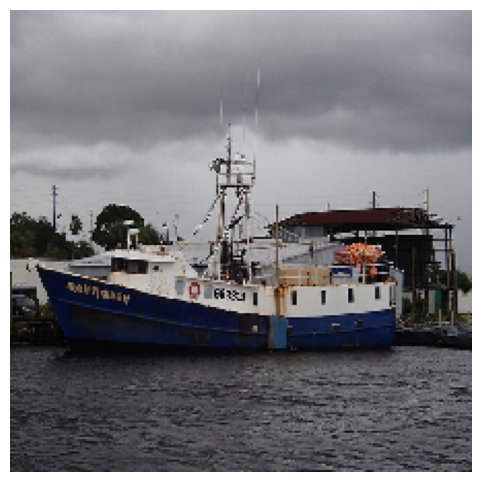


Predicted Image Caption:
a man is riding a surfboard on a surfboard

Oringinal Image Captions Train:
1: a couple of people riding a wave on surfboards
2: some people are riding surfboards on the waves
3: people on surfboards are riding the waves in the water
4: many people in the water some are surfing
5: a bunch of people in the water by a wave


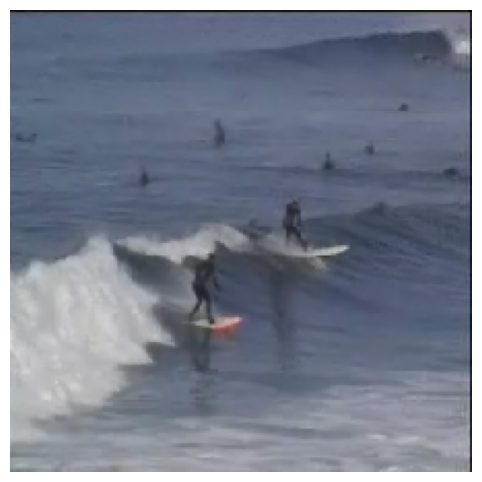


Predicted Image Caption:
a man is standing on a horse in a field

Oringinal Image Captions Train:
1: a cow walking on a path in the forest
2: a lone white cow walking down a dirt trail in a forest
3: a big cute cow walking on a path in the woods
4: a cow walking down a pathway in the woods
5: a white cow walks towards the camera on a small path through a green forest


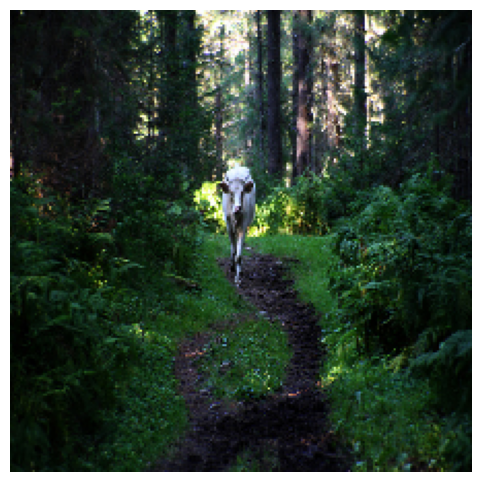


Predicted Image Caption:
a giraffe standing in a field with a giraffe

Oringinal Image Captions Train:
1: a giraffe and her calf walk in a zoo enclosure
2: large and a small giraffe in a fenced in location
3: a baby giraffe and its mother at the zoo
4: two giraffes stand side by side at a zoo
5: a big zebra and a baby zebra standing inside a fenced in area


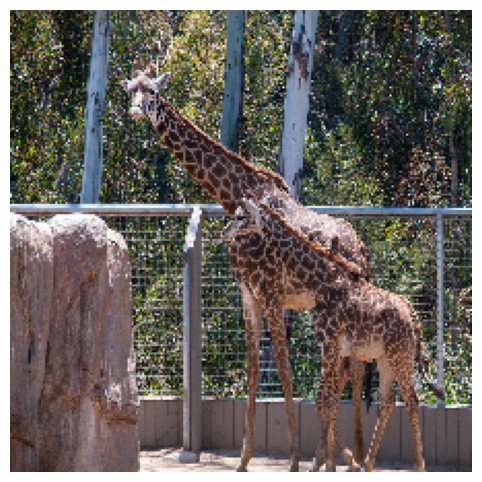


Predicted Image Caption:
a man is standing on a motorcycle with a horse

Oringinal Image Captions Train:
1: a young child standing along side railroad tracks
2: a woman with a bag stands beside a set of old railroad tracks
3: a woman at the railway line waiting for the train
4: a single person standing on the platform of a railway station seen through the trains window
5: a woman is leaning over by a train track


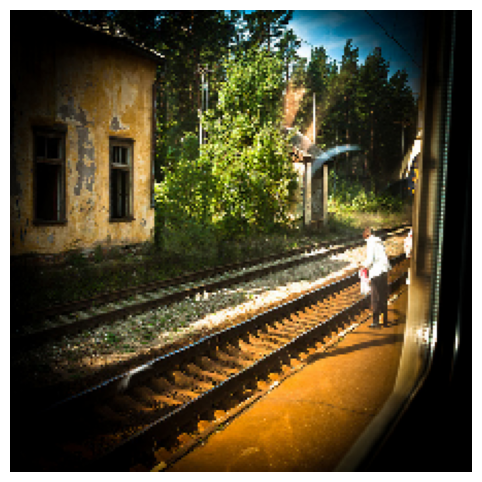


Predicted Image Caption:
a man is sitting on a table with a cell phone

Oringinal Image Captions Train:
1: a statute of a little boy holding a giant ice cream cone
2: a large display of a little boy licking a ice cream cone
3: a beer cooler stands behind a figure advertising ice cream
4: a plastic kid with an ice cream cone next to a freezer
5: a cooler full of beer and statue of a boy with an ice cream cone


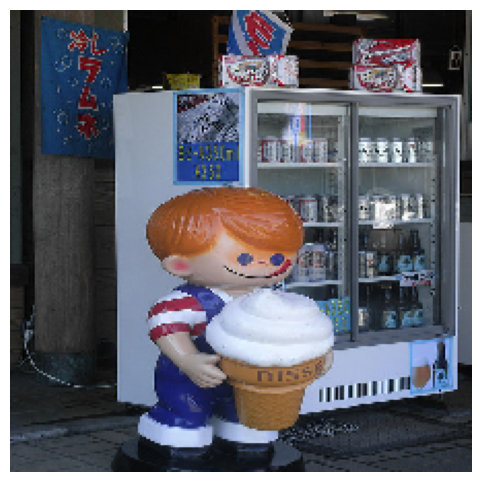


Predicted Image Caption:
a man is sitting on a couch with a laptop

Oringinal Image Captions Train:
1: a big dog standing and looking at a tv
2: a tan dog staring at the green television screen
3: a dog watching rabbits on a television screen
4: a dog up close looking at the television
5: a large golden dog is looking at a television screen


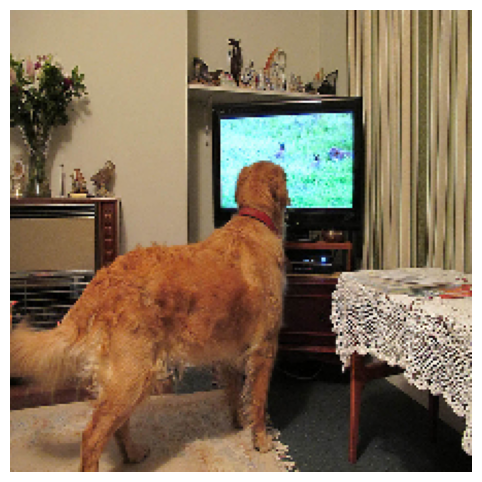


Predicted Image Caption:
a man is playing tennis on a tennis court

Oringinal Image Captions Train:
1: a man swinging a tennis racquet at a tennis ball
2: a tennis player about to swing at the tennis ball
3: there is a man swinging a tennis racket
4: a male tennis player is in action with the ball
5: a male tennis player is swinging at the ball


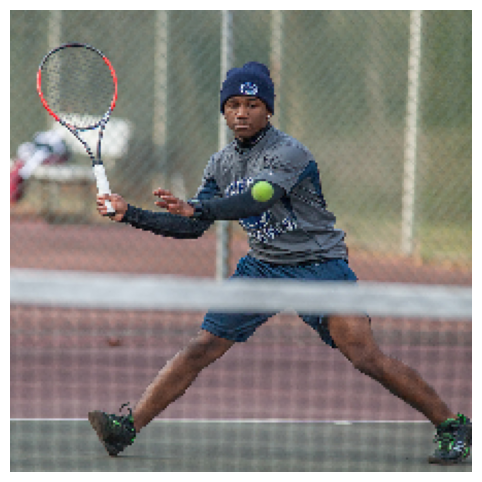


Predicted Image Caption:
a bathroom with a toilet and a toilet

Oringinal Image Captions Train:
1: a white bath tub sitting under a window in a bathroom
2: a bathroom with two toilets a counter a tub and several lights in it
3: a bath room with a bath tub and a toilet
4: a big bathroom with a big tub and a toilet
5: a bathroom with a bathtub and a mirror


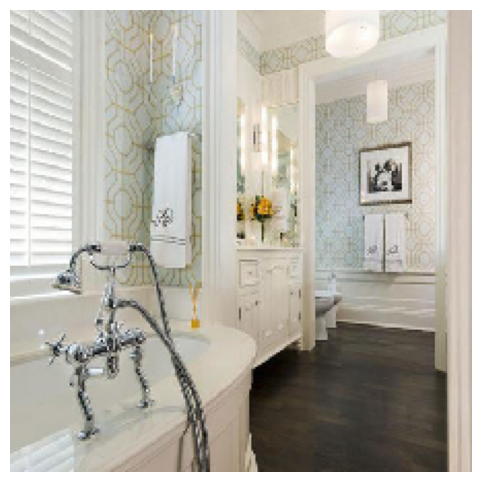


Predicted Image Caption:
a man riding a skateboard down a snowy slope

Oringinal Image Captions Train:
1: a man riding on top of a snow board down a ski slope
2: a man kneeling on a ski slope with a snowboard
3: a young man in skiing gear is posing for the camera
4: a man in black jacket sitting with a snowboard
5: there is a young man getting ready to ski


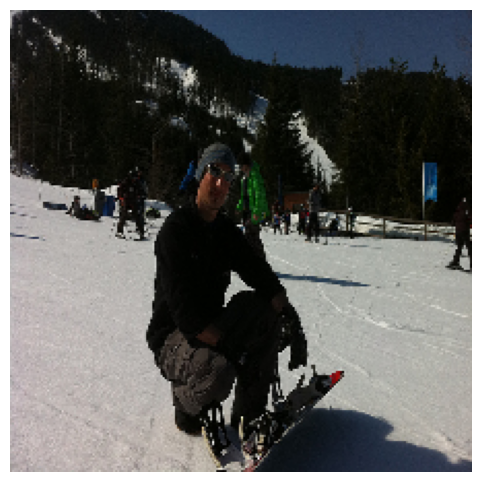

In [22]:
for i in range(10):
    get_captions(
        image_id=list(validation_features.keys())[i],
        image_captions=validation_captions, 
        image_features=validation_features, 
        image_path="./train2014", 
        model=model2,
        tokenizer=tokenizer,
        max_len=max_len
    )

In [9]:
# Make sure the model directory exists
os.makedirs("incep/model_1", exist_ok=True)

batch_size = 32
steps_per_epoch = len(training_features) // batch_size 

# Build the model
model = CNNLSTM_model(count, max_len)
epochs = 10

# Prepare datasets only once
dataset_train = data_generator(training_captions, training_features, tokenizer, max_len, count, batch_size)

#Save the model after each epoch 

checkpoint_callback = ModelCheckpoint(
    "incep/model_1/model_epoch_{epoch:02d}.h5",  # Path to save the model (using epoch number in filename)
    monitor="loss",  # Monitor the loss for saving (you can also use validation loss, etc.)
    verbose=1,  # Print out information when saving
    save_best_only=False,  # Set to True to save only the best model based on monitored value
    save_weights_only=False,  # Set to True if you want to save only model weights, not the entire model
    mode="min",  # "min" means saving when the loss decreases; can be "max" for accuracy-based models
)

# Train the model once
model.fit(
    dataset_train,  # Training data
    steps_per_epoch=steps_per_epoch,  # Number of steps per epoch for training
    epochs=epochs, 
    verbose=1,
    callbacks=[checkpoint_callback] 
)

# Save the model after training
model.save("incep/model_1/final_model.h5")

print("Training complete.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 51, 256)   │  6,344,704 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 51, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 51)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dense[0][0],      │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 24784)     │  6,369,488 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,829,840 (52.76 MB)

 Trainable params: 13,829,840 (52.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 5.5587
Epoch 1: saving model to incep/model_1/model_epoch_01.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 205s 98ms/step - loss: 5.5584
Epoch 2/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 4.3111
Epoch 2: saving model to incep/model_1/model_epoch_02.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 201s 97ms/step - loss: 4.3110
Epoch 3/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 4.1283
Epoch 3: saving model to incep/model_1/model_epoch_03.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 231s 112ms/step - loss: 4.1282
Epoch 4/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 3.9436
Epoch 4: saving model to incep/model_1/model_epoch_04.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 232s 112ms/step - loss: 3.9436
Epoch 5/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 3.8601
Epoch 5: saving model to incep/model_1/model_epoch_05.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 239s 116ms/step - loss: 3.8601
Epoch 6/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 3.7788
Epoch 6: saving model to incep/model_1/model_epoch_06.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 246s 119ms/step - loss: 3.7788
Epoch 7/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 3.7228
Epoch 7: saving model to incep/model_1/model_epoch_07.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 234s 113ms/step - loss: 3.7228
Epoch 8/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 3.6550
Epoch 8: saving model to incep/model_1/model_epoch_08.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 220s 106ms/step - loss: 3.6550
Epoch 9/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 3.6293
Epoch 9: saving model to incep/model_1/model_epoch_09.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 208s 100ms/step - loss: 3.6293
Epoch 10/10
2069/2069 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 3.5948
Epoch 10: saving model to incep/model_1/model_epoch_10.h5


2069/2069 ━━━━━━━━━━━━━━━━━━━━ 213s 103ms/step - loss: 3.5948


Training complete.


Test the model 

In [10]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    start = '<start>'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([start])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        pred = model.predict([image, sequence], verbose=0)
        # get index with high probability
        pred = np.argmax(pred)
        # convert index to word
        word = tokenizer.index_word.get(pred)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        start += " " + word
        # stop if we reach end tag
        if word == '<end>':
            break
    
    final_caption = start.split()
    final_caption = final_caption[1:-1]  # remove <start> and <end>
    final_caption = ' '.join(final_caption)
    return final_caption

Show images and predicted / original captions using the model 


Predicted Image Caption:
a man is holding a frisbee in the air

Oringinal Image Captions Train:
1: a boat named iron maiden in the water
2: a large fishing boat is on the dark water
3: a boat in the water on a cloudy day
4: a blue and white boat sitting in the water
5: a boat on the water on an overcast day


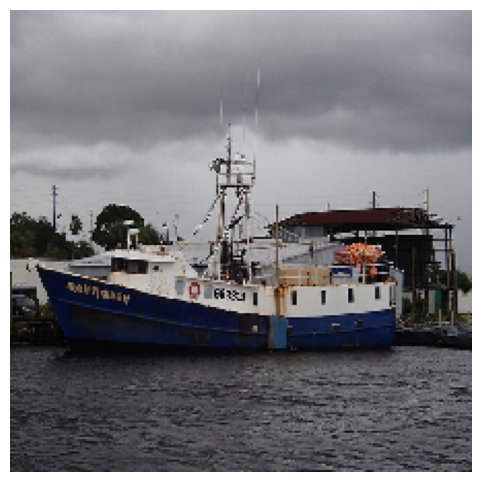


Predicted Image Caption:
a man is holding a frisbee in the air

Oringinal Image Captions Train:
1: a couple of people riding a wave on surfboards
2: some people are riding surfboards on the waves
3: people on surfboards are riding the waves in the water
4: many people in the water some are surfing
5: a bunch of people in the water by a wave


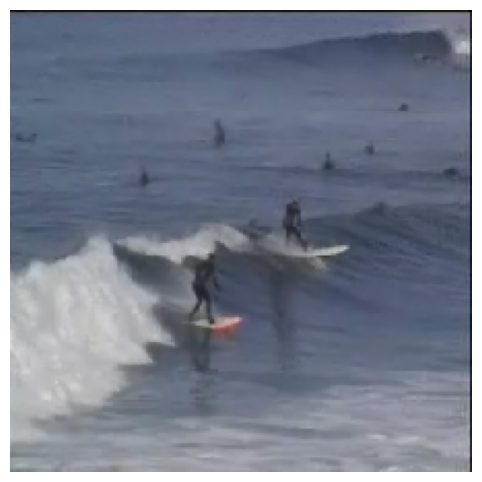


Predicted Image Caption:
a man is holding a frisbee in the air

Oringinal Image Captions Train:
1: a cow walking on a path in the forest
2: a lone white cow walking down a dirt trail in a forest
3: a big cute cow walking on a path in the woods
4: a cow walking down a pathway in the woods
5: a white cow walks towards the camera on a small path through a green forest


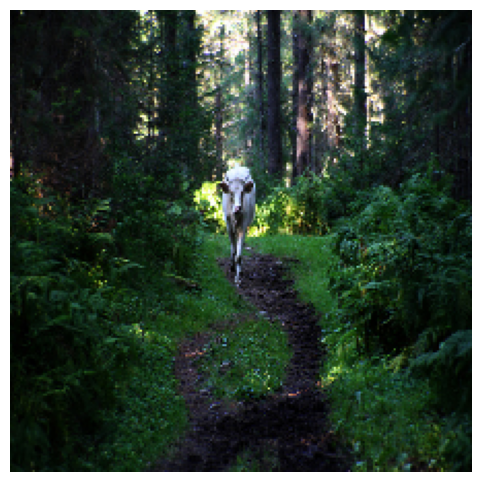


Predicted Image Caption:
a group of giraffes standing in the grass

Oringinal Image Captions Train:
1: a giraffe and her calf walk in a zoo enclosure
2: large and a small giraffe in a fenced in location
3: a baby giraffe and its mother at the zoo
4: two giraffes stand side by side at a zoo
5: a big zebra and a baby zebra standing inside a fenced in area


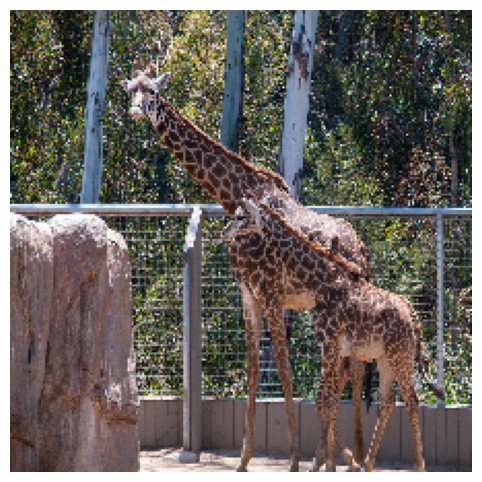


Predicted Image Caption:
a man is holding a frisbee in the air

Oringinal Image Captions Train:
1: a young child standing along side railroad tracks
2: a woman with a bag stands beside a set of old railroad tracks
3: a woman at the railway line waiting for the train
4: a single person standing on the platform of a railway station seen through the trains window
5: a woman is leaning over by a train track


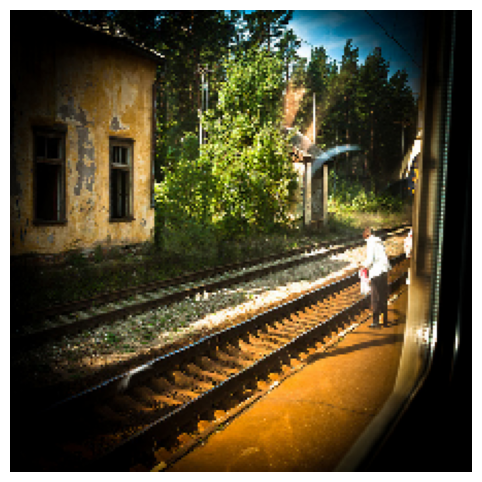


Predicted Image Caption:
a man is holding a frisbee in the air

Oringinal Image Captions Train:
1: a statute of a little boy holding a giant ice cream cone
2: a large display of a little boy licking a ice cream cone
3: a beer cooler stands behind a figure advertising ice cream
4: a plastic kid with an ice cream cone next to a freezer
5: a cooler full of beer and statue of a boy with an ice cream cone


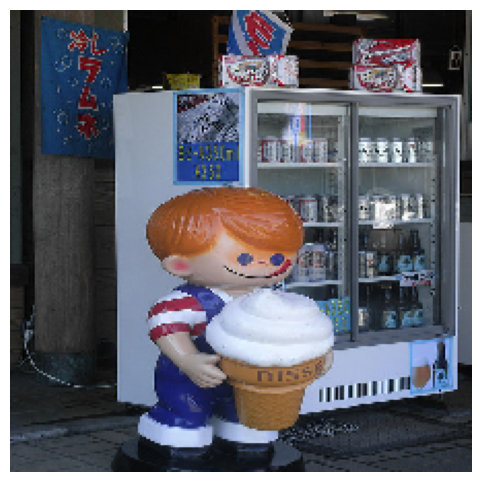


Predicted Image Caption:
a man is sitting on a table with a dog

Oringinal Image Captions Train:
1: a big dog standing and looking at a tv
2: a tan dog staring at the green television screen
3: a dog watching rabbits on a television screen
4: a dog up close looking at the television
5: a large golden dog is looking at a television screen


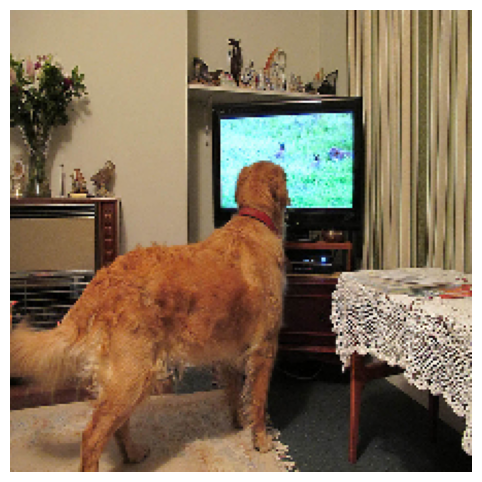


Predicted Image Caption:
a man is holding a tennis racket in the air

Oringinal Image Captions Train:
1: a man swinging a tennis racquet at a tennis ball
2: a tennis player about to swing at the tennis ball
3: there is a man swinging a tennis racket
4: a male tennis player is in action with the ball
5: a male tennis player is swinging at the ball


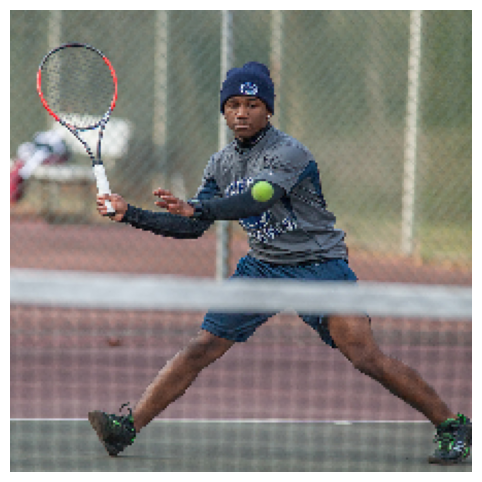


Predicted Image Caption:
a kitchen with a sink and a toilet and a sink

Oringinal Image Captions Train:
1: a white bath tub sitting under a window in a bathroom
2: a bathroom with two toilets a counter a tub and several lights in it
3: a bath room with a bath tub and a toilet
4: a big bathroom with a big tub and a toilet
5: a bathroom with a bathtub and a mirror


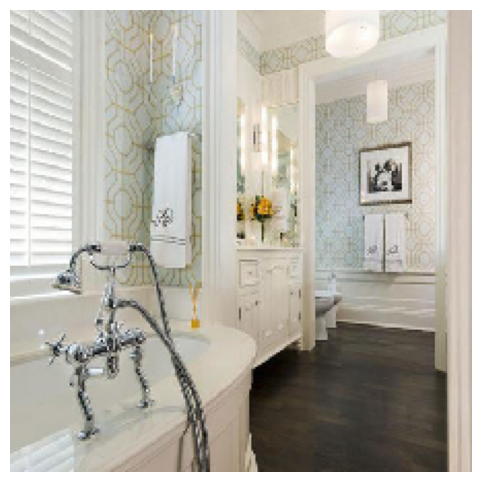


Predicted Image Caption:
a man is holding a kite in the air

Oringinal Image Captions Train:
1: a man riding on top of a snow board down a ski slope
2: a man kneeling on a ski slope with a snowboard
3: a young man in skiing gear is posing for the camera
4: a man in black jacket sitting with a snowboard
5: there is a young man getting ready to ski


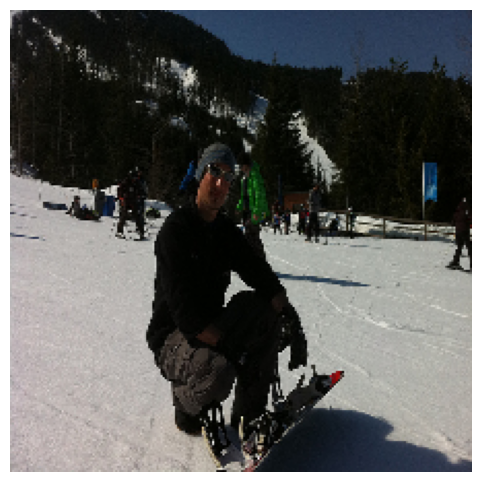

In [ ]:
# USED CNN MODEL 1
def get_captions(image_id, image_captions, image_features, image_path, model, tokenizer, max_len):

    # Get the image feature from val_image_features using the filename as the key
    image_feature = image_features.get(image_id, None)
    if image_feature is None:
        print(f"No features found for image ID {image_id}")
        return

    image_feature = image_feature.reshape((1, 2048))
    # Generate a caption using the trained model
    generated_caption = predict_caption(model, image_feature, tokenizer, max_len)

    # Show the image using the load_and_show_image function
    plt.figure(figsize=(8, 6))
    filename = image_id + ".jpg"
    img_path = os.path.join(image_path, filename)

    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')

    print("\nPredicted Image Caption:")
    print(generated_caption)

    # Retrieve and print the real captions
    print("\nOringinal Image Captions Train:")
    real_captions = image_captions.get(image_id, None) 

    if real_captions is None:
        print(f"No original captions found for image ID {image_id}")
    else:
        # Decode tokenized captions into words if they are tokenized
        for idx, caption in enumerate(real_captions):
            # If the caption is a list of token indices, decode it
            if isinstance(caption, list):
                decoded_caption = ' '.join([tokenizer.index_word.get(idx, '') for idx in caption if idx > 0])
                decoded_caption = decoded_caption.split()
                decoded_caption = decoded_caption[1:-1]  # remove <start> and <end>
                decoded_caption = ' '.join(decoded_caption)
                print(f"{idx + 1}: {decoded_caption}")
            else:
                # If it's already a string, simply print it
                print(f"{idx + 1}: {caption}")
            
    # Show the image with captions
    plt.show()

for i in range(10):
    get_captions(
        image_id=list(validation_features.keys())[i],
        image_captions=validation_captions, 
        image_features=validation_features, 
        image_path="./train2014", 
        model=model,
        tokenizer=tokenizer,
        max_len=max_len
    )


Test with validation 2014 

In [27]:
# Load train image features
with open('val2014_features.pkl', 'rb') as f:
    image_features = pickle.load(f)

# Load train tokienezd captions
with open('tokenized_val_captions2.pkl', 'rb') as f:
    tokenized_captions = pickle.load(f)

# Load tokenizer 
with open('tokenizer2.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [28]:
for i in range(10):
    get_captions(
        image_id=list(validation_features.keys())[i],
        image_captions=validation_captions, 
        image_features=validation_features, 
        image_path="./val2014", 
        model=model3,
        tokenizer=tokenizer,
        max_len=max_len
    )

FileNotFoundError: [Errno 2] No such file or directory: './val2014\\COCO_train2014_000000260955.jpg'

<Figure size 800x600 with 0 Axes>